In [1]:
from syne_tune import Tuner, StoppingCriterion
from syne_tune.backend import PythonBackend
from syne_tune.config_space import randint, uniform, loguniform
from syne_tune.optimizer.baselines import CQR
from syne_tune.experiments import load_experiment


In [13]:
def syne_trainer(
	## Fixed params
	epochs: int,
	checkpoint_interval: int,
	loss_reduction: str,
	data_path: str,
	ontology_name: str,
	tasks: str,
	## Tunable params
	batch_size: int,
	drop_p: float,
	enc_factor: int,
	weight_decay: float,
	beta: float,
	learning_rate: float,
	n_layers: int,
):
	## Load Dataset Container from pickle with already preprocessed data
	import pickle
	import sklearn
	from sklearn import linear_model
	import autoencodix as acx
	from autoencodix.configs.ontix_config import OntixConfig
	from syne_tune import Reporter
	
	file_pkl = data_path

	with open(file_pkl, "rb") as f:
		acx_container = pickle.load(f)

	scconfig = OntixConfig(
		## Fixed params
		epochs=epochs,
		checkpoint_interval= checkpoint_interval,
		loss_reduction= loss_reduction,
		## Tunable params
		batch_size= batch_size,
		drop_p= drop_p,
		enc_factor= enc_factor,
		weight_decay= weight_decay,
		beta= beta,
		learning_rate= learning_rate,
		n_layers= n_layers,
	)


	ont_files = [
		# Order from Latent Dim -> Hidden Dim -> Input Dim
		f"./llm_ontologies/{ontology_name}ensembl_level1.tsv",
		f"./llm_ontologies/{ontology_name}ensembl_level2.tsv",
		]

	ontix = acx.Ontix(
		data=acx_container,
		ontologies=ont_files,
		config=scconfig
		)

	ontix.run()

	## Embedding Evaluation
	sklearn.set_config(enable_metadata_routing=True)

	sklearn_ml_class = linear_model.LogisticRegression(
								solver="sag",
								n_jobs=-1,
								class_weight="balanced",
								max_iter=200,
	) 
	sklearn_ml_regression = linear_model.LinearRegression() ## Unused, only classification tasks
	own_metric_class = 'roc_auc_ovo'  
	own_metric_regression = 'r2' 

	tasks_list = tasks.split("$")
	ontix.evaluate(
		ml_model_class=sklearn_ml_class, 
		ml_model_regression=sklearn_ml_regression, 
		params= tasks_list,	
		metric_class = own_metric_class, 
		metric_regression = own_metric_regression, 
		reference_methods = [], # No reference methods for tuning
		split_type = "use-split",
		n_downsample = int(acx_container.train.data.shape[0]*0.5), # Use a subset of the data for faster evaluation
	)

	avg_mltask_performance = ontix.result.embedding_evaluation.loc[
		ontix.result.embedding_evaluation.score_split == "valid",
		"value"
	].mean()
	valid_recon_loss = ontix.result.sub_losses.get("recon_loss").get(epoch=-1, split="valid")

	report = Reporter()
	report(ml_performance=avg_mltask_performance, recon_loss=valid_recon_loss)

	# return avg_mltask_performance, valid_recon_loss

In [14]:
tasks = ["cell_type", "tissue", "development_stage", "sex"] ## Include disease later when available
ontology_name = "chatgpt_ontology__"
file_pkl = "./large_sc_data/large-ontix-processed-data.pkl"

# Hyperparameter configuration space
config_space = {
	## Fixed params
	"epochs": 10,
	"checkpoint_interval": 100,
	"loss_reduction": "sum",
	"data_path": file_pkl,
	"ontology_name": ontology_name,
	"tasks": "$".join(tasks),
	## Tunable params
	"batch_size": randint(32, 512),
	"drop_p": uniform(0.0, 0.9),
	"enc_factor": randint(1, 5),
	"weight_decay": loguniform(1e-5, 1e-1),
	"beta": loguniform(1e-5, 10),
	"learning_rate": loguniform(1e-5, 1e-1),
	"n_layers": randint(2, 5),
}

# Scheduler (i.e., HPO algorithm)
scheduler = CQR(
    config_space,
    metric="ml_performance",
    do_minimize=False
)

tuner = Tuner(
    trial_backend=PythonBackend(tune_function=syne_trainer, config_space=config_space),
    scheduler=scheduler,
    stop_criterion=StoppingCriterion(
		# max_wallclock_time=30,
		max_num_trials_completed=3,
		),
    n_workers=2,  # how many trials are evaluated in parallel
)


--------------------
Resource summary (last result is reported):
 trial_id     status  iter  epochs  checkpoint_interval loss_reduction                                      data_path      ontology_name                                  tasks  batch_size   drop_p  enc_factor  weight_decay     beta  learning_rate  n_layers  ml_performance  recon_loss  worker-time
        0  Completed     1      10                  100            sum ./large_sc_data/large-ontix-processed-data.pkl chatgpt_ontology__ cell_type$tissue$development_stage$sex         492 0.314395           2      0.001750 0.809875       0.053087         2        0.522030           -     0.000012
        1  Completed     1      10                  100            sum ./large_sc_data/large-ontix-processed-data.pkl chatgpt_ontology__ cell_type$tissue$development_stage$sex         258 0.739546           4      0.000022 0.086390       0.000064         3        0.614378           -     0.000010
        2  Completed     1      10       

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/syne_tune/experiments/experiment_result.py:138: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


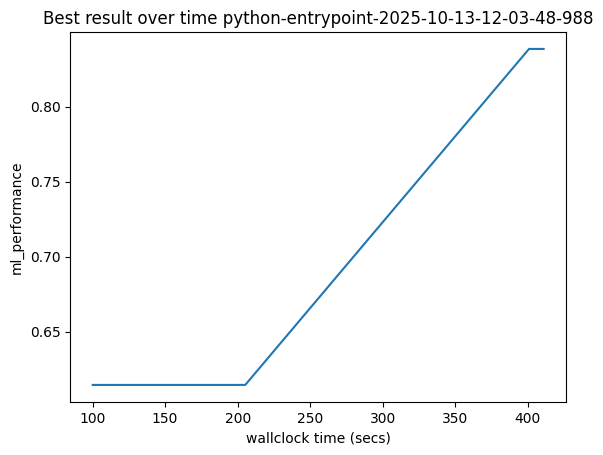

In [15]:
tuner.run()

tuning_experiment = load_experiment(tuner.name)

print(f"best result found: {tuning_experiment.best_config()}")

tuning_experiment.plot()